# OHBM 2020 - Open Science Room - Neurolang

## Priors and  increased specificity

### Background
The increasing availability of information describing cognitive structures and processes is a powerful driver for the adoption of meta-analysis techniques that help to synthesize large bodies of data from different studies[3-5]. This situation has also given rise to the advent of automated meta-analysis techniques, such as Neurosynth[1], which try to alleviate the high burden that information processing requires, to obtain a better performance for the volume of data processed. 

Since NeuroSynth was designed to extract information automatically, solving the problem generated by the explosive growth of human brain imaging literature in recent years[6], the results do not always have the required accuracy and specificity[2].

### Our approach
In this work, We present a possible solution to some of these problems through the use of priors. We are going to show how we can add a prior to the results obtained through meta-analysis techniques, allowing us to specify the region in a precise manner, reducing the area covered by the responses obtained, thus decreasing the variance and increasing the statistical power of the analysis.

#### Let's begin

In [1]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.probabilistic_frontend import ProbabilisticFrontend
from rdflib import RDFS
from nilearn import plotting
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterable
from neurolang import frontend as fe

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 fro

In [2]:
nl = ProbabilisticFrontend()
datasets_helper.load_auditory_datasets(nl)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  return self.volume.get_header()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:624: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  old_data = self.data.to_dense()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:634: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  self.data = data.fillna(0.0).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/generic.py:3607: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.

In [3]:
paths = 'neurolang_data/ontologies/neurofma_fma3.0.owl'
nl.load_ontology(paths)

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/ontologies_parser.py:231: UserWarning: The restriction minCardinality cannot be
            parsed for http://sig.biostr.washington.edu/fma3.0#Organ_with_organ_cavity.
  parsed for {restricted_node}."""


In [12]:
label = nl.new_symbol(name=str(RDFS.label))
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))
regional_part = nl.new_symbol(name='http://sig.biostr.washington.edu/fma3.0#regional_part_of')

@nl.add_symbol
def agg_create_region(x: Iterable, y: Iterable, z: Iterable) -> fe.ExplicitVBR:
    mni_t1 = it.masker.volume
    voxels = nib.affines.apply_affine(np.linalg.inv(mni_t1.affine), np.c_[x, y, z])
    return fe.ExplicitVBR(voxels, mni_t1.affine, image_dim=mni_t1.shape)

with nl.environment as e:    
    e.fma_related_region[e.subregion_name, e.entity_name] = (
        label(e.fma_uri, e.entity_name) &
        regional_part(e.fma_region, e.fma_uri) &
        subclass_of(e.fma_subregion, e.fma_region) &
        label(e.fma_subregion, e.subregion_name)
    )
    
    e.fma_related_region[e.recursive_region, e.fma_name] = (
        subclass_of(e.recursive_region, e.fma_subregion) & e.fma_related_region(e.fma_subregion, e.fma_name)
    )
    
    e.fma_to_destrieux[e.fma_name, e.destrieux_name] = (
        label(e.fma_uri, e.fma_name) & e.relation_destrieux_fma(e.destrieux_name, e.fma_name)
    )
    
    e.destrieux_to_neurosynth[e.destrieux_name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.destrieux_labels[e.id_destrieux, e.destrieux_name] &
        e.xyz_destrieux[e.x, e.y, e.z, e.id_destrieux] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )


In [13]:
with nl.scope as e:
    e.region_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.fma_related_region[e.fma_subregions, 'Temporal lobe'] & 
        e.fma_to_destrieux[e.fma_subregions, e.destrieux_name] & 
        e.destrieux_to_neurosynth[e.destrieux_name, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.p_act[e.id_voxel, e.term] = (
        e.p_voxel_study[e.id_voxel, e.id_study] & 
        e.p_term_study[e.term, e.id_study] & 
        e.p_study[e.id_study]
    )
    
    e.probability_voxel[e.x, e.y, e.z, e.term] = (
        e.p_act[e.id_voxel, e.term] &
        e.region_voxels[e.id_voxel, e.x, e.y, e.z]
    )
    
    nl_act_term_study = nl.solve_query(e.probability_voxel[e.x, e.y, e.z, e.term])

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [11]:
with nl.scope as e:
    e.p_ts[e.term] = (
        e.p_term_study[e.term, e.id_study] & 
        e.p_study[e.id_study]
    )
    
    nl_term_study = nl.solve_query(e.p_ts[e.term])

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [14]:
df_conj = nl_act_term_study.value.as_pandas_dataframe()
df_ts = nl_term_study.value.as_pandas_dataframe()

In [15]:
df_conj_prob_column = df_conj.drop(['term', 'x', 'y', 'z'], axis=1).columns[0]
df_conj = df_conj.rename(columns={f'{df_conj_prob_column}': "prob1"})
df_conj.head()

,z,x,term,y,prob1
0,-46.0,-44.0,auditory,-10.0,4.695505e-14
1,-46.0,-44.0,auditory,-8.0,6.217865e-14
2,-46.0,-44.0,auditory,-6.0,6.154390e-14
3,-46.0,-42.0,auditory,-10.0,4.695505e-14
4,-46.0,-42.0,auditory,-8.0,6.217865e-14


In [16]:
df_ts_prob_column = df_ts.drop(['term'], axis=1).columns[0]
df_ts = df_ts.rename(columns={f'{df_ts_prob_column}': "prob2"})
df_ts.head()

,term,prob2
0,auditory,8.222620e-07


In [17]:
df_merge = df_conj.merge(df_ts, left_on='term', right_on='term')

In [18]:
df_merge['prob'] = df_merge['prob1'] / df_merge['prob2']

In [22]:
from nilearn import datasets, image
nsh = fe.neurosynth_utils.NeuroSynthHandler()
ns_ds = nsh.ns_load_dataset()
it = ns_ds.image_table

dd = datasets.fetch_atlas_destrieux_2009()
destrieux_to_ns_mni = image.resample_to_img(
    dd["maps"], it.masker.volume, interpolation="nearest"
)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  return self.volume.get_header()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:624: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  old_data = self.data.to_dense()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:634: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  self.data = data.fillna(0.0).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argume

In [19]:
df_merge = df_merge[['x', 'y', 'z', 'prob']]

In [20]:
df_merge.head()

,x,y,z,prob
0,-44.0,-10.0,-46.0,5.710473e-08
1,-44.0,-8.0,-46.0,7.561903e-08
2,-44.0,-6.0,-46.0,7.484707e-08
3,-42.0,-10.0,-46.0,5.710473e-08
4,-42.0,-8.0,-46.0,7.561903e-08


In [23]:
import nibabel as nib
from neurolang.regions import region_union
from tqdm import tqdm_notebook

def create_region(x, y, z, it):
    voxels = nib.affines.apply_affine(
        np.linalg.inv(it.affine), np.c_[x, y, z]
    )
    return fe.ExplicitVBR(voxels, it.affine, image_dim=it.shape)


regions = []
vox_prob = []
for x, y, z, p in tqdm_notebook(df_merge.values):
    r_overlay = create_region(x, y, z, it.masker.volume)
    vox_prob.append((r_overlay.voxels, p))
    regions.append(r_overlay)

regions = region_union(regions)

prob_img_nl = nib.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=destrieux_to_ns_mni.affine
)
for v, p in tqdm_notebook(vox_prob):
    prob_img_nl.dataobj[tuple(v.T)] = p


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


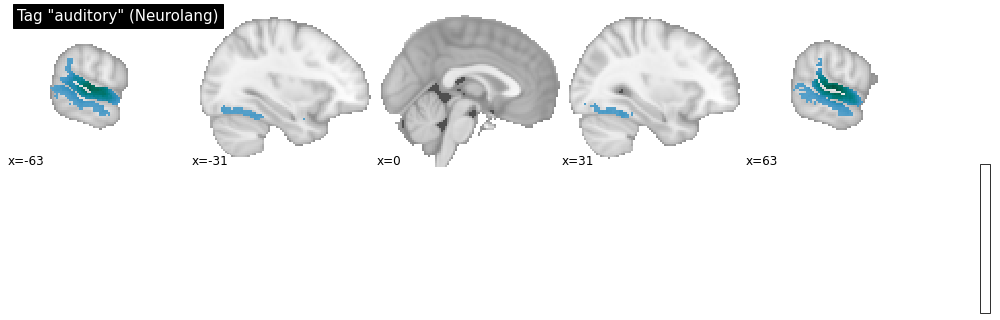

In [24]:
#prob_img_nl = datasets_helper.parse_results(nl_results)
plotting.plot_stat_map(
    prob_img_nl, 
    title='Tag "auditory" (Neurolang)', 
    cmap='PuBuGn',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

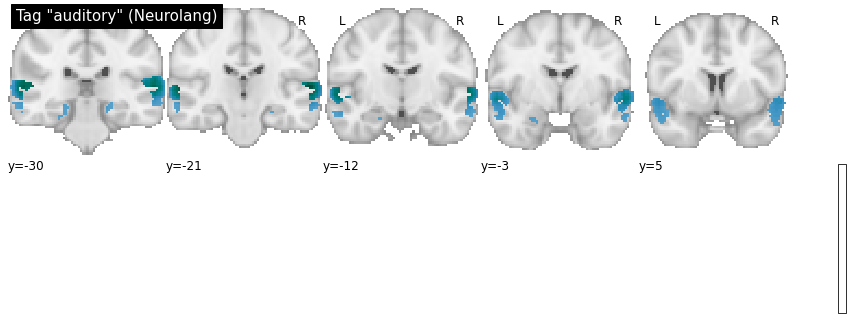

In [25]:
plotting.plot_stat_map(
    prob_img_nl, title='Tag "auditory" (Neurolang)', 
    cmap='PuBuGn',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

In [8]:
with nl.scope as e:
    
    e.p_act[e.id_voxel, e.term, e.id_study] = (
        e.p_voxel_study[e.id_voxel, e.id_study] & 
        e.p_term_study[e.term,  e.id_study] & 
        e.p_study[e.id_study]
    )
    
    e.probability_voxel[e.x, e.y, e.z] = (
        e.p_act[e.id_voxel, e.term, e.id_study] &
        e.region_voxels[e.id_voxel, e.x, e.y, e.z]
    )
    
    ns_results = nl.solve_query(e.probability_voxel[e.x, e.y, e.z])

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:146: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/probabilistic/weighted_model_counting.py:521: RuntimeWarning: divide by zero encountered in log
  wmc.set_literal_weights_from_array(np.log(weights))


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


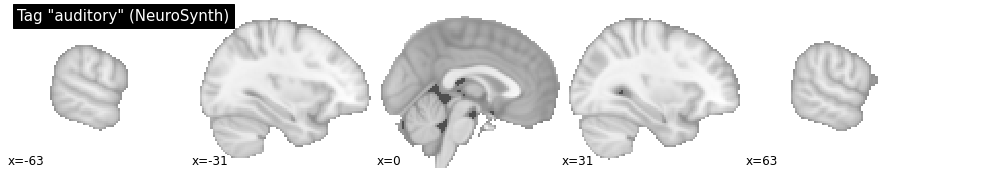

In [9]:
prob_img_ns = datasets_helper.parse_results(ns_results)
plotting.plot_stat_map(
    prob_img_ns, 
    title='Tag "auditory" (NeuroSynth)', 
    cmap='PuBu',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

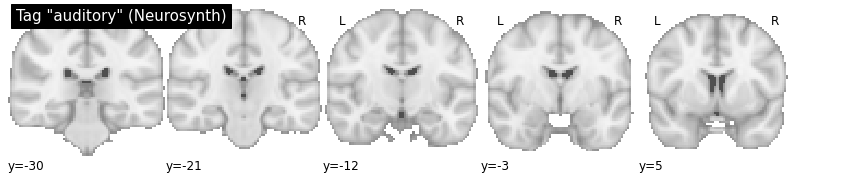

In [10]:
plotting.plot_stat_map(
    prob_img_ns, 
    title='Tag "auditory" (Neurosynth)', 
    cmap='PuBu',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

Now we can analyze the results by plotting the p-values obtained. Let's start with the NeuroLang results.

In [23]:
res, p_values_corrected, p_value_image = stats_helper.compute_p_values(prob_img, q=1e-25)

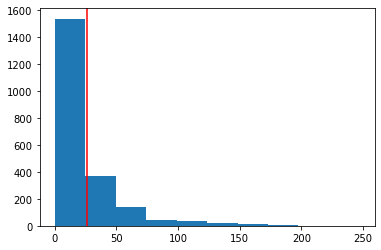

In [24]:
plt.hist(-np.log10(res))
plt.axvline(-np.log10(p_values_corrected), c='r')

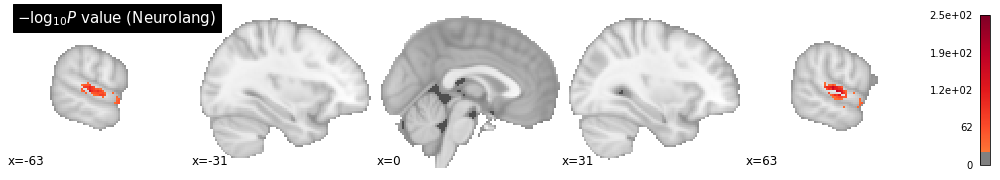

In [25]:
plotting.plot_stat_map(
    p_value_image, 
    title=r'$-\log_{10} P$ value (Neurolang)', 
    threshold=-np.log10(p_values_corrected), 
    cmap='YlOrRd',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

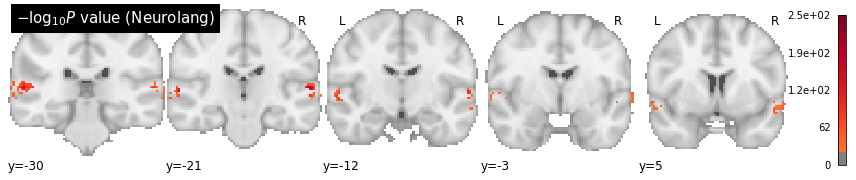

In [26]:
plotting.plot_stat_map(
    p_value_image, title=r'$-\log_{10} P$ value (Neurolang)', 
    threshold=-np.log10(p_values_corrected),
    cmap='YlOrRd',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

In [27]:
res, p_values_corrected, p_value_image = stats_helper.compute_p_values(prob_img_ns, q=1e-25)

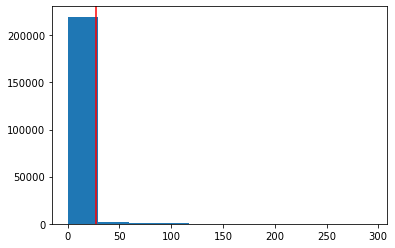

In [28]:
plt.hist(-np.log10(res))
plt.axvline(-np.log10(p_values_corrected), c='r')

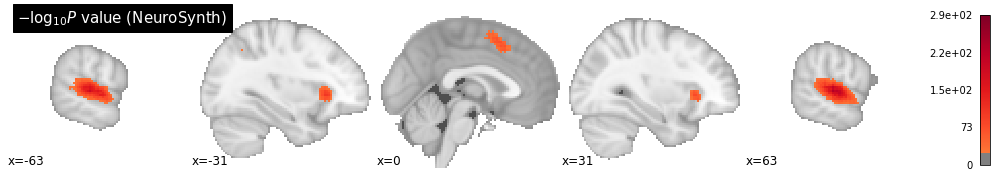

In [29]:
plotting.plot_stat_map(
    p_value_image, 
    title=r'$-\log_{10} P$ value (NeuroSynth)', 
    threshold=-np.log10(p_values_corrected), 
    cmap='YlOrRd',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

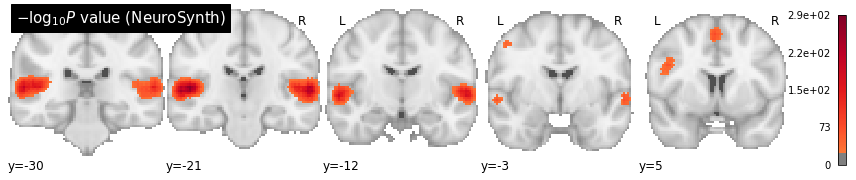

In [30]:
plotting.plot_stat_map(
    p_value_image, title=r'$-\log_{10} P$ value (NeuroSynth)', 
    threshold=-np.log10(p_values_corrected),
    cmap='YlOrRd',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

#### References
[1] Yarkoni, T.: Neurosynth core tools v0.3.1, DOI: 10.5281/zenodo.9925 (2014). <br/>
[2] Yarkoni, T., Poldrack, R. A., Nichols, T. E., Van Essen, D. C. & Wager, T. D: Large-scale automated synthesis of human functional neuroimaging data. Nat. Methods 8, 665–670, DOI: 10.1038/nmeth.1635 (2011). <br/>
[3] News. Journal of Investigative Medicine 58 (8), 929 (Dec2010). https://doi.org/10.2310/JIM.0b013e3182025955, http://jim.bmj.com/content/58/8/929.abstract <br/>
[4] Insel, T. R., Landis, S.C., Collins, F.S.: Research priorities. The NIHBRAIN Initiative. Science (New York, N.Y.) 340 (6133), 687–688 (May  2013). https://doi.org/10.1126/science.1239276 <br/>
[5] Markram, H.: The human brain project. Scientific American306(6), 50–55 (Jun2012). https://doi.org/10.1038/scientificamerican0612-50
[6] Derrfuss, J. & Mar, R. A. Lost in localization: the need for a universal coordinate database. NeuroImage 48, 1–7, DOI:10.1016/j.neuroimage.2009.01.053 (2009).